# Create cleaned ESTC data set to run Biterm Topic Models

- **Author/methods:** James Sanders
- **SME on dataset and subject matter:** Austen Saunders

In [1]:
# Load libraries
import pandas as pd
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from thefuzz import fuzz
import numpy as np
from tqdm import tqdm

# Initialise stemmer
ps = PorterStemmer()

# Base stopwords from nltk
base_stopwords = stopwords.words("english")

# Additional stopwords from analysing intermediate outputs
additional_stopwords = [
    # Generic words
    "also", "ad", "may", "upon", "unto", "one", "sic",
    # Common names
    "thomas", "john", "robert", "richard", "george", "henry", "andrew", "ralph", "matthew", "mr",
    # Translation-related words
    "translated", "translation", "englished", "edited"
]

# Combine stopwords
combined_stopwords = base_stopwords + additional_stopwords

pd.options.mode.chained_assignment = None

## Load raw ESTC data

Number of records: 137327
Date range: 1473 to 1700


,system_number,citation_number,name,name_dates,name_type,role,all_names,title,date,publisher,country,city,place,physical_description,pages,format,language
0,6180992,S109298,"Lefèvre, Raoul",active 1460,person,NaN,"Mansion, Colard, printer [person] ; Caxton, Wi...",hEre begynneth the volume intituled and named ...,1473.0,"Printed by William Caxton and, probably, Colar...",Belgium,Bruges,"[Bruges : Printed by William Caxton and, proba...",[704] p. ; 2?.,704.0,folio,eng
1,6178187,S106478,"Cessolis, Jacobus de",NaN,person,NaN,"Mansion, Colard, printer [person] ; Caxton, Wi...","[T] o the right noble, right excellent [and] v...",1474.0,"Printed by William Caxton and Colard Mansion,",Belgium,Bruges,[Bruges : Printed by William Caxton and Colard...,[148] p. ; 2?.,148.0,folio,eng
2,6194414,S123061,"Lefèvre, Raoul",active 1460,person,NaN,"Caxton, William, approximately 1422-1491 or 14...",Cy commence le volume intitule le recueil des ...,1474.0,"printed by William Caxton and, probably, Colar...",Belgium,Bruges,"[Ghent?] : [David Aubert?, for William Caxton]...",[572] p. ; 2?.,572.0,folio,fre
3,6192096,S120723,Catholic Church,NaN,organisation,NaN,Catholic Church [organisation],Breviarium ad usum Sarum,1475.0,"s.n.,",Netherlands,Southern Netherlands,"[Southern Netherlands : s.n., ca. 1475?]",[2+] leaves ; 4?.,4.0,quarto,lat
4,6178189,S106480,NaN,NaN,NaN,NaN,"Caxton, William, approximately 1422-1491 or 14...",Hic incipit paruus Catho,1476.0,"Printed by William Caxton,",England,Westminster,"[Westminster : Printed by William Caxton, 1476]",[66] p. ; 4?.,66.0,quarto,eng


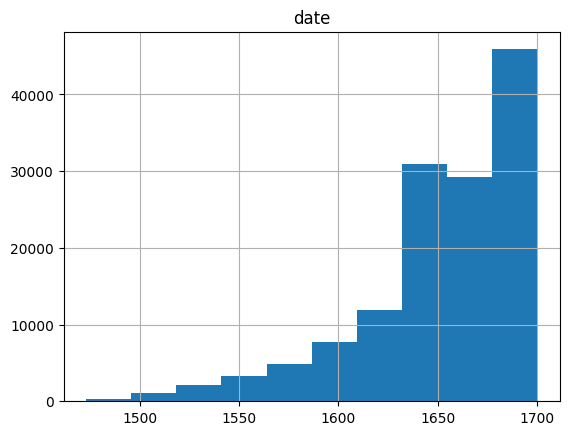

In [5]:
# Load data
raw_data = pd.read_csv("/Users/jamiesanders/Dropbox/ClassifyingESTC/input_files/estc_with_pages.csv", encoding = "ISO-8859-1")

# Some stats
print("Number of records: " + str(len(raw_data)))
print("Date range: " + str(int(min(raw_data["date"]))) + " to " + str(int(max(raw_data["date"]))))

# Quick Histogram of dates
raw_data.hist("date")

# Let's see!
raw_data.head()

## Remove rows we don't want

Below I implement the following rules to remove certain records.

1) Language is "eng"
2) Narrow the range of dates (1600-1699) to avoid topics being based purely on drift of style over centuries.
3) Remove all duplicate titles in the same year (exact duplicates and user-controlled near duplicates).
3) Remove all records that have less than 4 words after words are stemmed, stopwords removed and one-letter words removed.

In the process of executing number (3), only characters and spaces are kept, and titles are converted to lower case.

In [6]:
# (1) Implement language selection
filtered_data = raw_data[raw_data["language"] == "eng"]

In [7]:
# (2) Implement Date range
filtered_data = filtered_data[(filtered_data["date"] >= 1600) & (filtered_data["date"] < 1700)]

In [8]:
# (3) Remove dulicates
# Takes around 30 mins to run

# Type string
filtered_data["title"] = filtered_data["title"].astype(str)

# Function to remove duplicates (can be improved on)
# 100 is identical text, 0 is completely different.
# If you only want to remove exact duplicates, set fuzzythreshold=101
def remove_duplicates(df, fuzzythreshold):
    
    # Remove exact duplicates
    df = df.drop_duplicates(subset = "title")
    
    # Fuzzy matching on the remaining records...
    
    # Take a given row
    for i in df.index:
        
        # go to next loop if we have removed that index already
        if i not in df.index:
            
            continue
        
        # Then loop through each row
        for comparison in df.index:
            
            # check we haven't already removed this index and aren't comparing to itself
            if (comparison in df.index) and (i != comparison):

                # Otherwise calculate the similarity using Levenshtein Distance
                sim = fuzz.ratio(df['title'][i], df['title'][comparison])

                # Check if more similar than threshold
                if sim >= fuzzythreshold:

                    # If it is, then print the decision -- leave commented or a lot of output!!
                    # Useful for demos though
                    # print(df['title'][i] + ' -------' + str(sim) + '-------- ' + df['title'][comparison])

                    # Remove the duplicate row
                    df = df.drop(index = comparison)
                
    return(df)

# Prep a couple variables
rem = 0
filtered_data_deduped = pd.DataFrame()

# Run through years
for year in tqdm(range(1600,1700)):
    
    # Extract year subset
    year_data = filtered_data[filtered_data['date'] == year]
    
    # Run deduper
    deduped_year = remove_duplicates(year_data, 93) # Any lower than 93 and you get more non-duplicates being removed
    
    # Keep track of number removed
    rem += len(year_data) - len(deduped_year)
    
    # Reconstruct df
    filtered_data_deduped = pd.concat([filtered_data_deduped, deduped_year])

    
print(str(rem) + " duplicates removed.")

#### This code is for Demos ####
# # Extract year subset
# year_data = filtered_data[filtered_data['date'] == 1685]

# # Run deduper
# deduped_year = remove_duplicates(year_data, 93)


100%|█████████████████████████████████████████| 100/100 [30:06<00:00, 18.06s/it]

13206 duplicates removed.


Number of records: 94690


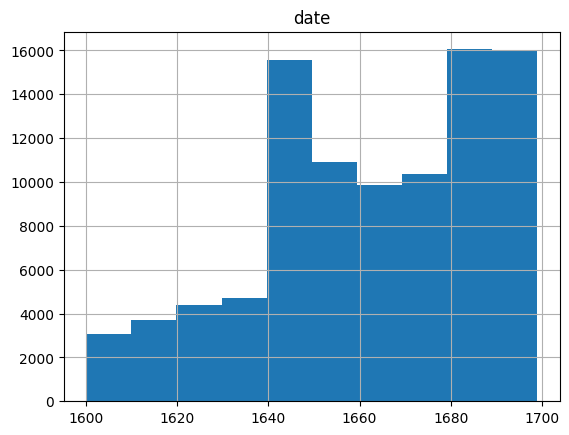

In [9]:
# (4) Function to stem, remove stopwords and remove one-letter words
def stemtexts(text):
    
    # Keep just characters, spaces and numbers
    text = re.sub('[^a-zA-Z\s]+', '', text)
    
    # convert to lowercase
    text = text.lower()
    
    # Tokenise
    words = word_tokenize(text)
    
    # Stem, remove stopwords
    filtered_words = [ps.stem(word) for word in words if word not in combined_stopwords and len(word) >= 2]
    
    # paste back together
    clean_text = " ".join(filtered_words)

    return(clean_text)

# Apply function
filtered_data_deduped["clean_title"] = filtered_data_deduped["title"].apply(stemtexts)

# Keep only >=4 words (Yan, Xiaohui, et al. keeps all >1 !!)
filtered_data_deduped = filtered_data_deduped.loc[[len(s.split()) >= 4 for s in filtered_data_deduped["clean_title"]] , ]

# Quick Histogram of dates
filtered_data_deduped.hist("date")

# Number of records
print("Number of records: " + str(len(filtered_data_deduped))) # lost ~200 documents by removing numbers

## Save

In [11]:
# Keep some key fields
processed_data = filtered_data_deduped[["system_number", "date", "pages", "format", "title", "clean_title"]]

# Save to dropbox
processed_data.to_csv("/Users/jamiesanders/Dropbox/ClassifyingESTC/input_files/estc_with_pages.csv")

# Let's see!
processed_data.head()

,system_number,date,pages,format,title,clean_title
15353,6172522,1600.0,1.0,broadside,By the Queene. Whereas the Earle of Essex : ac...,queen wherea earl essex accompani earl rutland...
15354,6180391,1600.0,584.0,octavo,Essayes : By Sir William Corne-Waleys the youn...,essay sir william cornewaley younger knight
15355,6206783,1600.0,576.0,octavo,"The booke of common prayer, and administration...",book common prayer administr sacrament rite ce...
15369,6205242,1600.0,1.0,half_sheet,Immortalitas animarum naturaliter innotescit,immortalita animarum naturalit innotescit
15377,6205278,1600.0,1.0,half_sheet,Plantæ viuaciores sunt animalibus,plant viuacior sunt animalibu
